# Otimização de Parâmetros de Estoque 

Inclusão das Bibliotecas

In [ ]:
pip install pygmo

     |████████████████████████████████| 11.5MB 5.5MB/s 


In [ ]:
pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 5.2MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894069 sha256=ff5a5b4c36722c785082d193c9dd6b70c197839c771a6ffb61eae501858c5b1f
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import norm
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import math
from pygmo import *

Confugração do Problema

In [ ]:
# Aqui você deve colocar as características do seu estoque

# Parâmetros do Estoque a ser Otimizado
A = 80 # custo de uma solicitação de um compra
D = 3412 # demanda anual média
h = 0.26 # taxa de manutenção de estoque (carrying rate)
c = 27.5 # custo de uma unidade do produto
sigma_L = 53.354 # desvio padrão da quantidade de vendas até a chegada  de um pedido
mi_L = D/12 # demanda prevista durante o tempo de espera do pedido, ou seja, pode ser a média mensal se demora 1 mês pra chegar


# Variáveis que vão ser usadas na otimização
#Q = # tamanho do pedido
#k = # fator de segurança

k_minimo = 1.00 # fator de segurança mínimo
k_maximo = 3.00 # fator de segurança máximo
Q_minimo = 100 # tamanho mínimo do pedido
Q_maximo = 800 # tamanho máximo do pedido


# Objetivos a otimizar
#C = # Minimizar - custo esperado por ano para configuração e manutenção de estoque
#S = # Minimizar - número esperado de ocasiões de escassez por ano

# Variáveis de Cálculo
#fi =  # função de distribuição de probabilidade
#FI =  # função de distribuição cumulativa
#r =  # ponto que quando alcançado precisa ser feita uma nova ordem de compra
# L  = # tempo do pedido até a chegada do produto na prateleira (lead time), consireraremos como 1 mês
# D_L = # demanda durante o lead time, é normalmente distribuído com média mi_L e desvio padrão sigma_L



Definições do Sistema

In [ ]:
# Não deve mexer aqui, são as configurações do algoritmo

class inventory():
  def __init__(self):
    self.A = A # custo de uma solicitação de um compra
    self.D = D # demanda anual média
    self.h = h # taxa de transporte de estoque (carrying rate)
    self.c = c # custo de uma unidade do produto
    self.sigma_L = sigma_L # desvio padrão da quantidade de vendas até a chegada  de um pedido
    self.mi_L = mi_L # demanda prevista durante o tempo de espera do pedido, ou seja, pode ser a média mensal se demora 1 mês pra chegar
    
  # C = (A*D/Q) + h*c*((Q/2) + k*sigma_L)
  # S =(D*sigma_L/Q)*  (fi - k*(1- FI))

  def return_R(self, k):
    """Retorna o ponto de reabastecimento."""
    self.r = self.mi_L + k*self.sigma_L
    return self.r

  def return_S (self, Q, k):
    self.S = (self.D/Q) * (1 - st.norm.cdf(k)) # P(z>=k), que é (1 - P(z <= k)), que é (1 - A(k))
    return self.S

  def return_C (self, Q, k):
    # Por ser a função de probabilidade normal standard o sigma é 1 e o mi é 0
    self.bins = k
    self.sigma_standard = 1
    self.mi_standard = 0
    self.FI = st.norm.cdf(k)#scipy.stats.norm.cdf(k)
    self.fi = (1/(self.sigma_standard * np.sqrt(2 * np.pi))) * np.exp( - (self.bins - self.mi_standard)**2 / (2 * self.sigma_standard**2)) # (1/(np.sqrt(np.pi))) * np.exp( - (self.bins )**2 )   #
    self.C = ((self.A*self.D)/Q) + self.h*self.c*((Q/2) + k*self.sigma_L + (self.D*self.sigma_L/Q)* (self.fi - k*(1- self.FI)) )
    return self.C



class optimization_problem():

    def fitness(self, x_var):  # x_var = [Q, k]
        #f1 = 1/self.model.return_S # problema de maximização
        f1 = self.model.return_S(x_var[0], x_var[1]) # problema de minimização
        f2 = self.model.return_C(x_var[0], x_var[1]) # problema de minimização
        return (f1, f2)

    # equality constraints
    def get_nec(self):
        return 0

    def get_nobj(self):
        """Return number of objectives."""
        return 2

    # inequality constraints
    def get_nic(self):
        return 0

    def get_bounds(self): # x_var = [Q, k]
        """Return bounds of decision variables."""
        return ([Q_minimo, k_minimo], [Q_maximo, k_maximo])
    
optimize = optimization_problem()
optimize.model = inventory()

Primeiro Teste


In [ ]:
# Assim você pode fazer testes dos valores de Q e k como quiser
#   Esse tipo de procedimento é o que é feito hoje, os gerentes decidem o que acham que são bons valores e vão testando

estoque = inventory()
print("Custo anual do estoque: " + str(estoque.return_C(180, 1.65)))
print("Probabilidade de faltar estoque: " + str(estoque.return_S(180, 1.65)))
print("Ponto de pedido: " + str(estoque.return_R(1.65)))
""" Escolhendo essa configuração de Q = 180 e k = 1.65, o estoque vai custar caro e sempre vai faltar produto """

Custo anual do estoque: 2938.618265425719
Probabilidade de faltar estoque: 0.9377591607267074
Ponto de pedido: 372.36743333333334


' Escolhendo essa configuração de Q = 180 e k = 1.65, o estoque vai custar caro e sempre vai faltar produto '

Otimização Inteligente


______________________________________________________
Resultado da Otimização
______________________________________________________

Custo de Estoque e Probabilidade de Falta de Estoque
[[9.91273381e-01 2.67477538e+03]
 [5.75787630e-03 4.34612268e+03]
 [5.75787630e-03 4.34612268e+03]
 [4.57091794e-01 2.72047571e+03]
 [7.83489676e-01 2.68032720e+03]
 [1.18406205e-02 3.23809595e+03]
 [5.89393630e-03 4.28821459e+03]
 [3.07711004e-01 2.76505901e+03]
 [6.94304691e-03 3.93537123e+03]
 [1.46325912e-01 2.85276820e+03]
 [8.52863215e-03 3.58152290e+03]
 [6.99966603e-03 3.91946247e+03]
 [1.17312578e-02 3.56546726e+03]
 [8.97901931e-02 2.91451245e+03]
 [3.12936915e-01 2.76311863e+03]
 [2.91550892e-02 3.05334124e+03]]

Tamanho do Pedido e Fator de Segurança
[[301.13895403   1.35638357]
 [799.95633861   2.99998694]
 [799.95633861   2.99998694]
 [292.8953471    1.75959793]
 [301.11298382   1.48219748]
 [389.0040765    2.99998694]
 [781.50059209   2.99998263]
 [316.97848549   1.90198306]
 [665.9413

Text(0.5, 1.0, 'ZDT1: ... and the evolved population')

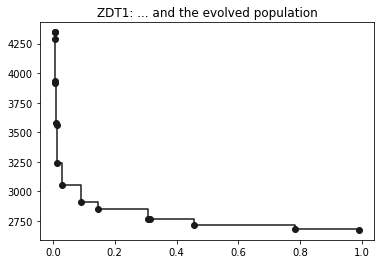

In [ ]:
import pygmo as pg


prob = pg.problem(optimize)

alg = pg.nsga2()
pop = pg.population(prob, size= 16, seed = 1)
algo = pg.algorithm(pg.nsga2(gen=100))
pop = algo.evolve(pop)
fits, vectors = pop.get_f(), pop.get_x()
print('')
print('______________________________________________________')
print('Resultado da Otimização')
print('______________________________________________________')
print('')
print("Custo de Estoque e Probabilidade de Falta de Estoque")
print(fits)
print('')
print("Tamanho do Pedido e Fator de Segurança")
print(vectors)
print('')
ax = plot_non_dominated_fronts(pop.get_f()) 
plt.title("ZDT1: ... and the evolved population")  



In [ ]:
pop

Problem name: <class '__main__.optimization_problem'>
	C++ class name: pybind11::object

	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			2
	Number of objectives:			2
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [100, 1]
	Upper bounds: [800, 3]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 1616

	Thread safety: none

Population size: 16

List of individuals: 
#0:
	ID:			17669943048939433521
	Decision vector:	[301.139, 1.35638]
	Fitness vector:		[0.991273, 2674.78]
#1:
	ID:			9835163641955136003
	Decision vector:	[799.956, 2.99999]
	Fitness vector:		[0.00575788, 4346.12]
#2:
	ID:			12762880030118587160
	Decision vector:	[799.956, 2.99999]
	Fitness vector:		[0.00575788, 4346.12]
#3:
	ID:			5820236150515825707
	Decision vector:	[292.895, 1.7596]
	Fitness vector:		[0.457092, 2720.48]
#4:

In [ ]:
df_solutions = pd.DataFrame(columns = ['S', 'C', 'Q', 'k', 'Ponto de Pedido' ])
for i in range (0, len(vectors)):
  dict_solution = {'S' : fits[i][0], 'C' : fits[i][1], 'Q' : vectors[i][0], 'k' : vectors[i][1], 'Ponto de Pedido': estoque.return_R(vectors[i][1]) }
  df_solutions.loc[i] = dict_solution
df_solutions

,S,C,Q,k,Ponto de Pedido
0,0.991273,2674.775379,301.138954,1.356384,356.701823
1,0.005758,4346.122683,799.956339,2.999987,444.394636
2,0.005758,4346.122683,799.956339,2.999987,444.394636
3,0.457092,2720.475712,292.895347,1.759598,378.214921
4,0.783490,2680.327195,301.112984,1.482197,363.414498
5,0.011841,3238.095948,389.004077,2.999987,444.394636
6,0.005894,4288.214587,781.500592,2.999983,444.394407
7,0.307711,2765.059011,316.978485,1.901983,385.811737
8,0.006943,3935.371226,665.941394,2.998824,444.332603
9,0.146326,2852.768202,292.895347,2.239521,403.820744


 # Suporte a Decisão com Lógica Fuzzy

Vamos utilizar um sistema de suporte a decisão para rotular automaticamente cada uma das soluções e escolher a melhor de acordo com as preferências da gerência

In [ ]:
import skfuzzy as fuzz # Mamdani Fuzzy, The system use max for aggregation , centroid for defuzzification as default
from skfuzzy import control as ctrl

Aqui você pode definir os critérios gerencias do que é um alto, médio ou baixo valor do Custo Anual do Estoque

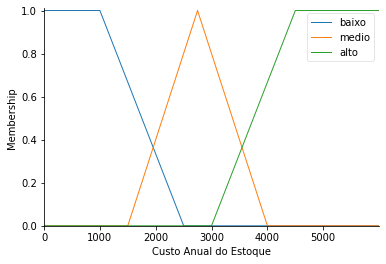

In [ ]:
valor = ctrl.Antecedent(np.arange(0, 6000, 1), 'Custo Anual do Estoque')

valor['baixo'] = fuzz.trapmf(valor.universe, [0, 0, 1000, 2500])
valor['medio'] = fuzz.trimf(valor.universe, [1500, 2750, 4000])
valor['alto']  = fuzz.trapmf(valor.universe, [3000, 4500, 6000, 6000])

valor.view()

Aqui você pode definir os critérios gerencias do que é uma alta, média ou baixa Probabilidade de Estoque Acabar

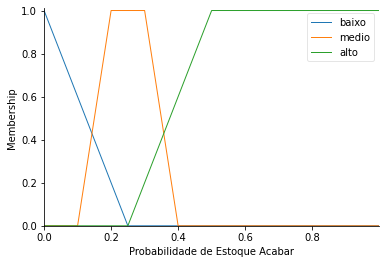

In [ ]:
prob_stockout = ctrl.Antecedent(np.arange(0, 1.0, 0.001), 'Probabilidade de Estoque Acabar')

prob_stockout['baixo'] = fuzz.trimf(prob_stockout.universe, [0, 0, 0.25])
prob_stockout['medio'] = fuzz.trapmf(prob_stockout.universe, [0.1, 0.2, 0.3, 0.4])
prob_stockout['alto']  = fuzz.trapmf(prob_stockout.universe, [0.25, 0.5, 1.0 , 1.0])

prob_stockout.view()

Aqui se define entre 0 a 100 o que é um estoque ruim, bom custo benefício ou muito bom

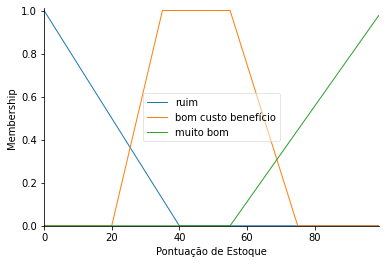

In [ ]:
decisao = ctrl.Consequent(np.arange(0, 100, 1), 'Pontuação de Estoque')

decisao['ruim'] = fuzz.trimf(decisao.universe, [0,0,40])
decisao['bom custo benefício'] = fuzz.trapmf(decisao.universe,  [20, 35, 55,75])
decisao['muito bom']  = fuzz.trimf(decisao.universe, [55, 100, 100])

decisao.view()

Definição das Regras de Negócio

In [ ]:
regra1 = ctrl.Rule(valor['baixo']  & prob_stockout['baixo']  ,  decisao['muito bom'])
regra2 = ctrl.Rule(valor['medio'] & prob_stockout['baixo'],  decisao['bom custo benefício'])
regra3 = ctrl.Rule(valor['baixo']  & prob_stockout['medio'],  decisao['bom custo benefício'])
regra4 = ctrl.Rule(valor['alto']  | prob_stockout['alto'],   decisao['ruim'])

# Cria um sistema de controle e uma simulação
inventory_ctrl = ctrl.ControlSystem([regra1, regra2, regra3, regra4])
inventory_sim = ctrl.ControlSystemSimulation(inventory_ctrl)

Assim pode-se testar o sistema de suporte a decisão para valores conhecidos

In [ ]:
# Entrada
inventory_sim.input['Custo Anual do Estoque'] = 3800
inventory_sim.input['Probabilidade de Estoque Acabar'] = 0.15

# Calcula
inventory_sim.compute()
inventory_sim.output

OrderedDict([('Pontuação de Estoque', 26.141246047862552)])

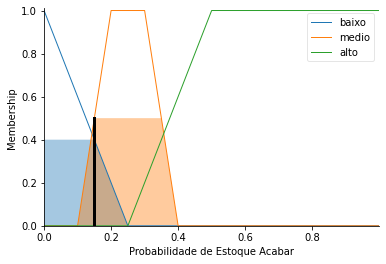

In [ ]:
prob_stockout.view(sim=inventory_sim)

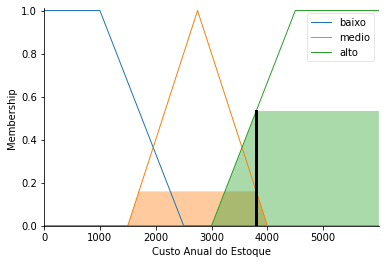

In [ ]:
valor.view(sim=inventory_sim)

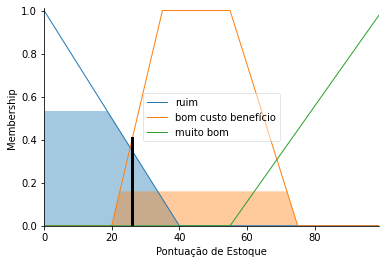

In [ ]:
decisao.view(sim=inventory_sim)

Criação de uma Função para Automatizar os Cálculos

In [ ]:
def ic(configuracao_estoque):
   # Entrada
   inventory_sim.input['Custo Anual do Estoque'] = configuracao_estoque[0]
   inventory_sim.input['Probabilidade de Estoque Acabar'] = configuracao_estoque[1]

   # Calcula
   inventory_sim.compute()
   return(inventory_sim.output['Pontuação de Estoque'])

Resultado do Sistema de Suporte a Decisão para as saídas geradas pelo Otimizador

In [ ]:
df_solutions = pd.DataFrame(columns = ['S', 'C', 'Q', 'k', 'Ponto de Pedido', 'Pontuação de Estoque' ])
for i in range (0, len(vectors)):
  dict_solution = {'S' : fits[i][0], 'C' : fits[i][1], 'Q' : vectors[i][0], 'k' : vectors[i][1], 'Ponto de Pedido': estoque.return_R(vectors[i][1]), 'Pontuação de Estoque' :  ic([fits[i][1], fits[i][0]])  }
  df_solutions.loc[i] = dict_solution
df_solutions

,S,C,Q,k,Ponto de Pedido,Pontuação de Estoque
0,0.991273,2674.775379,301.138954,1.356384,356.701823,13.333333
1,0.005758,4346.122683,799.956339,2.999987,444.394636,13.460594
2,0.005758,4346.122683,799.956339,2.999987,444.394636,13.460594
3,0.457092,2720.475712,292.895347,1.759598,378.214921,13.668567
4,0.783490,2680.327195,301.112984,1.482197,363.414498,13.333333
5,0.011841,3238.095948,389.004077,2.999987,444.394636,42.787550
6,0.005894,4288.214587,781.500592,2.999983,444.394407,13.566244
7,0.307711,2765.059011,316.978485,1.901983,385.811737,17.791964
8,0.006943,3935.371226,665.941394,2.998824,444.332603,18.766849
9,0.146326,2852.768202,292.895347,2.239521,403.820744,47.007895


Quais são as melhores soluções de acordo com os critérios da equipe gerencial?